In [66]:
# Import dependencies and libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

***READ THE DATA***

In [67]:
cab_df = pd.read_csv("data/cab_rides.csv")
weather = pd.read_csv("data/weather.csv")

***VIEW DATA***

In [68]:
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [69]:
weather.head()

,temperature,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


***DATA CLEANING***

In [70]:
# Unify timestamp format & convert to datetime
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp'] / 1000, unit='s')
weather['date_time'] = pd.to_datetime(weather['time_stamp'], unit='s')


In [71]:
# Create a merge_date key
cab_df['merge_date'] = (
    cab_df['source'].astype(str)
    + " - " + cab_df['date_time'].dt.date.astype(str)
    + " - " + cab_df['date_time'].dt.hour.astype(str)
)
weather['merge_date'] = (
    weather['location'].astype(str)
    + " - " + weather['date_time'].dt.date.astype(str)
    + " - " + weather['date_time'].dt.hour.astype(str)
)

In [72]:
# Group weather by merge_date and handle missing rain values
groupby_value = (
    weather.groupby('merge_date', as_index=False)
           .mean(numeric_only=True)
)
if 'rain' in groupby_value.columns:
    groupby_value['rain'].fillna(0, inplace=True)

In [73]:
# Merge the cab df with weather df using join
groupby_value.set_index('merge_date', inplace=True)
merged_df = cab_df.join(groupby_value, on='merge_date', rsuffix='_w')


In [74]:
# Drop missing values
merged_df.dropna(inplace=True)
print("Merged dataset shape:", merged_df.shape)
merged_df.head(5)

Merged dataset shape: (635242, 19)


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date,temperature,clouds,pressure,rain,time_stamp_w,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000105,Haymarket Square - 2018-12-16 - 9,38.460,0.290000,1022.25,0.000,1.544954e+09,0.760000,7.68
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677000046,Haymarket Square - 2018-11-27 - 2,44.065,0.995000,1002.88,0.106,1.543286e+09,0.895000,12.63
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000072,Haymarket Square - 2018-11-30 - 4,35.080,0.000000,1013.71,0.000,1.543554e+09,0.700000,5.25
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000050,Haymarket Square - 2018-11-29 - 3,37.680,0.433333,998.42,0.000,1.543461e+09,0.706667,11.16
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,2018-12-17 18:25:12.138000011,Haymarket Square - 2018-12-17 - 18,40.780,0.930000,1000.15,0.000,1.545072e+09,0.790000,7.55


In [75]:
# Filter Uber data
merged_df = merged_df[merged_df['cab_type'] == 'Uber']

print("Filtered dataset shape:", merged_df.shape)
merged_df.head()

Filtered dataset shape: (329140, 19)


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date,temperature,clouds,pressure,rain,time_stamp_w,humidity,wind
12,1.11,Uber,1543615981179,West End,North End,12.0,1.0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-30 22:13:01.178999901,North End - 2018-11-30 - 22,38.65,0.96,1017.23,0.0000,1.543618e+09,0.65,3.13
13,1.11,Uber,1544698211014,West End,North End,16.0,1.0,23f145da-f0c1-4d1f-a184-496bc003a7db,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-13 10:50:11.013999939,North End - 2018-12-13 - 10,20.12,0.43,1031.07,0.0000,1.544698e+09,0.64,3.88
14,1.11,Uber,1544728503935,West End,North End,7.5,1.0,357559cb-8c58-4278-a41a-e33b2e0997a3,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-12-13 19:15:03.934999943,North End - 2018-12-13 - 19,32.75,0.51,1033.75,0.0000,1.544730e+09,0.57,1.90
15,1.11,Uber,1545004511430,West End,North End,7.5,1.0,50ef1165-9d23-416c-a65c-18906207b295,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-12-16 23:55:11.430000067,North End - 2018-12-16 - 23,42.36,1.00,1012.15,0.2088,1.545004e+09,0.77,11.46
16,1.11,Uber,1544748007961,West End,North End,26.0,1.0,91c4861c-1780-42b0-bca1-bbd64a422cc3,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-14 00:40:07.960999966,North End - 2018-12-14 - 0,30.07,0.69,1034.97,0.0000,1.544748e+09,0.68,1.98


***PERFORMING EDA***

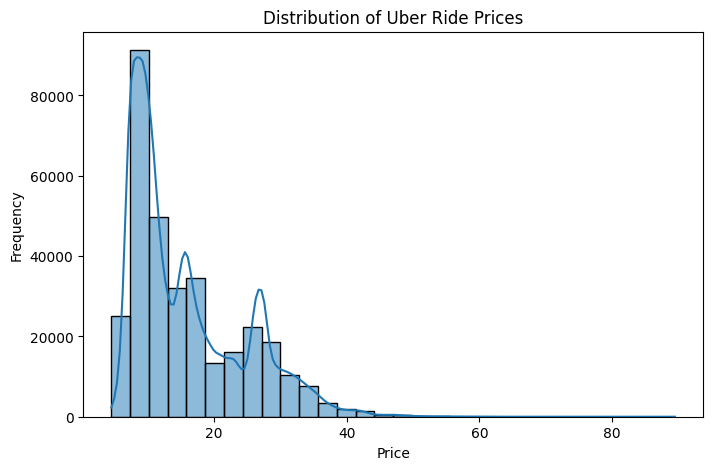

In [76]:
# Plotting the distribution of Price
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['price'], kde=True, bins=30)
plt.title("Distribution of Uber Ride Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

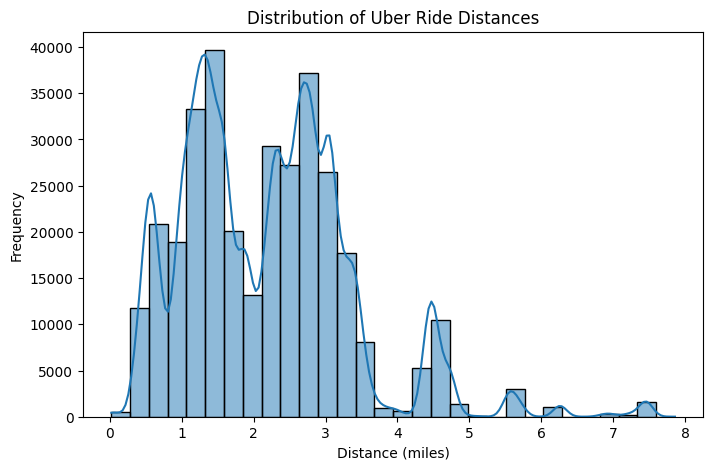

In [77]:
# Plotting the distribution of Distance
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['distance'], kde=True, bins=30)
plt.title("Distribution of Uber Ride Distances")
plt.xlabel("Distance (miles)")
plt.ylabel("Frequency")
plt.show()


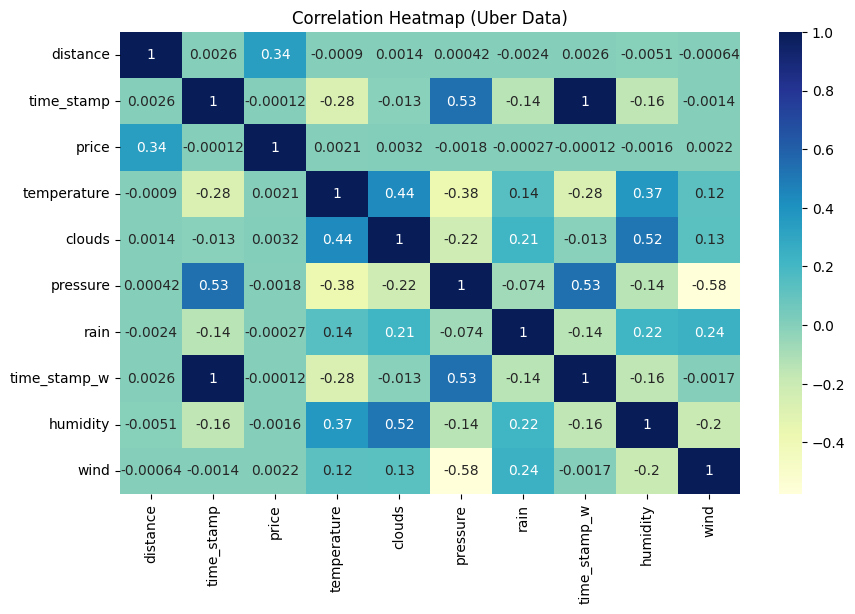

In [78]:
# Correlation matrix
df_cleaned_corr = merged_df.loc[:, merged_df.nunique() > 1]
corr = df_cleaned_corr.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Uber Data)")
plt.show()

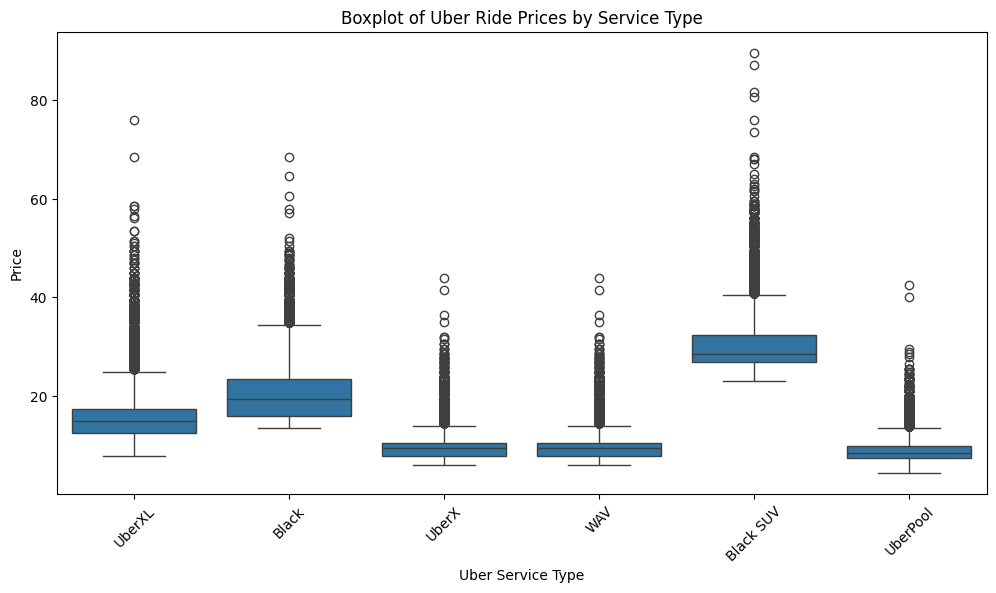

In [79]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='name', y='price')
plt.title("Boxplot of Uber Ride Prices by Service Type")
plt.xlabel("Uber Service Type")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

***CREATING MODELS***

In [80]:
df_model = merged_df.copy()

# Identify features and target
numeric_cols = ["distance", "surge_multiplier", "temperature", "clouds",
                "pressure", "rain", "humidity", "wind"]
categorical_cols = ["source", "name"]
df_model.dropna(subset=numeric_cols + categorical_cols + ["price"], inplace=True)

X = df_model[numeric_cols + categorical_cols]
y = df_model["price"]

# One-hot encode the categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Feature shape:", X_encoded.shape)
print("Target shape:", y.shape)

Feature shape: (329140, 24)
Target shape: (329140,)


In [81]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape, "\nTest set size:", X_test.shape)

Train set size: (263312, 24) 
Test set size: (65828, 24)


In [82]:
# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_lin = lin_reg.predict(X_test)

# Evaluation
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression Metrics")
print("RMSE:", rmse_lin)
print("MAE:", mae_lin)
print("R^2 :", r2_lin)

Linear Regression Metrics
RMSE: 2.4128366053881036
MAE: 1.6524351257125007
R^2 : 0.9205635162977321


In [83]:
# XGBoost Regression Model
xgb_reg = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_reg.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_reg.predict(X_test)

# Evaluation
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Metrics")
print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)
print("R^2 :", r2_xgb)

XGBoost Regression Metrics
RMSE: 1.9019567252755771
MAE: 1.173320805055081
R^2 : 0.9506411027500657


In [84]:
# Comparison of Linear Regression v/s XGBoost Model Performance
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost"],
    "RMSE": [rmse_lin, rmse_xgb],
    "MAE": [mae_lin, mae_xgb],
    "R^2": [r2_lin, r2_xgb]
})

comparison_df

,Model,RMSE,MAE,R^2
0,Linear Regression,2.412837,1.652435,0.920564
1,XGBoost,1.901957,1.173321,0.950641


In [ ]:
# Compare Models
# Used generative AI to compare both the models
df_results_lin = pd.DataFrame({
    "Actual": y_test,
    "Predicted_LinReg": y_pred_lin
}).reset_index(drop=True)
df_results_lin["AbsoluteDiff_LinReg"] = abs(df_results_lin["Actual"] - df_results_lin["Predicted_LinReg"])

df_results_xgb = pd.DataFrame({
    "Actual": y_test,
    "Predicted_XGB": y_pred_xgb
}).reset_index(drop=True)
df_results_xgb["AbsoluteDiff_XGB"] = abs(df_results_xgb["Actual"] - df_results_xgb["Predicted_XGB"])

df_compare = pd.concat([df_results_lin, df_results_xgb[["Predicted_XGB", "AbsoluteDiff_XGB"]]], axis=1)

print("Comparison DataFrame:")
df_compare.head()

Comparison DataFrame:


,Actual,Predicted_LinReg,AbsoluteDiff_LinReg,Predicted_XGB,AbsoluteDiff_XGB
0,12.0,11.817322,0.182678,10.871494,1.128506
1,7.0,5.698670,1.301330,7.202868,0.202868
2,15.5,10.907370,4.592630,10.493919,5.006081
3,11.5,13.214144,1.714144,13.285077,1.785077
4,15.0,17.604795,2.604795,15.778174,0.778174


***PLOTS BASED ON ACTUAL AND PREDICTED VALUES***

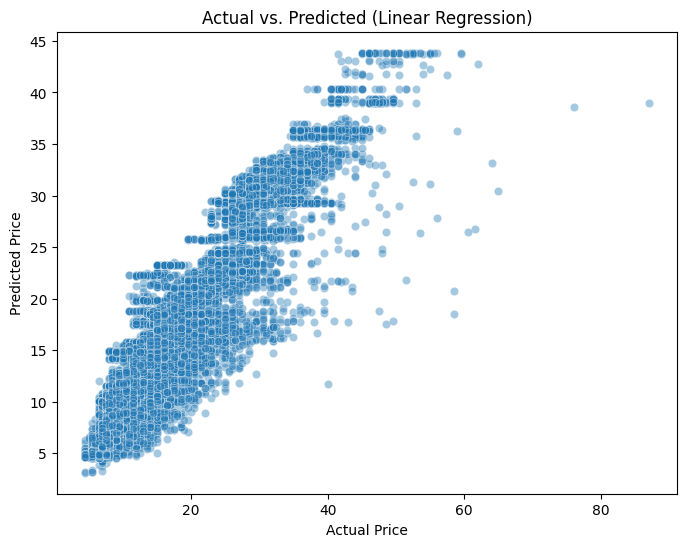

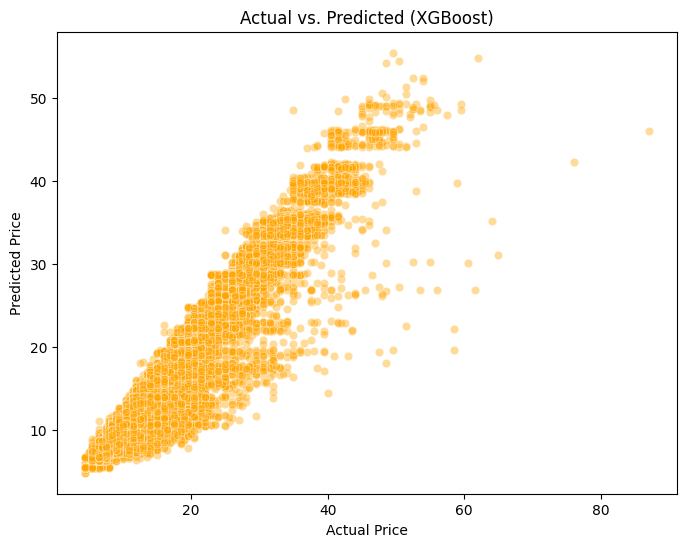

In [86]:
# Scatter Plot: Actual vs. Predicted (Linear Regression)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_results_lin, x="Actual", y="Predicted_LinReg", alpha=0.4)
plt.title("Actual vs. Predicted (Linear Regression)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# Scatter Plot: Actual vs. Predicted (XGBoost)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_results_xgb, x="Actual", y="Predicted_XGB", alpha=0.4, color="orange")
plt.title("Actual vs. Predicted (XGBoost)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

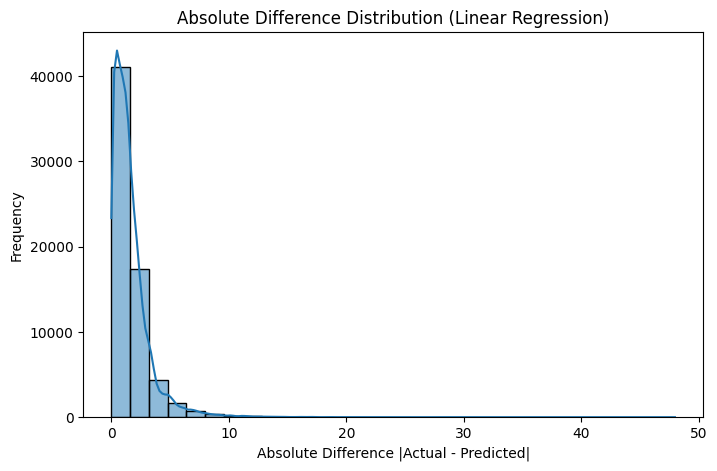

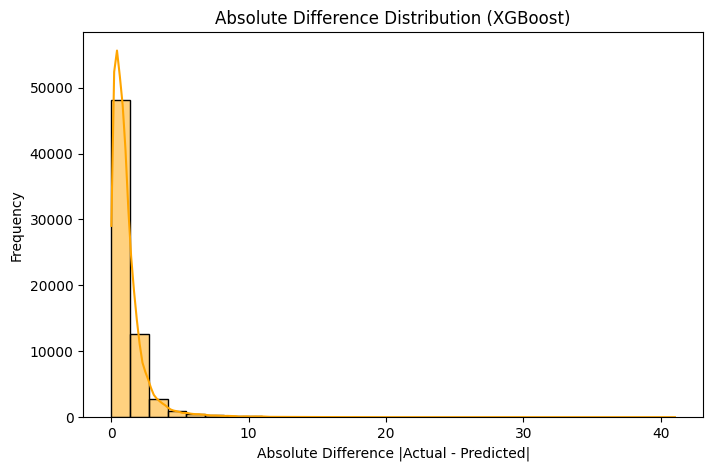

In [87]:
# Distribution of Absolute Differences (Linear Regression)
plt.figure(figsize=(8, 5))
sns.histplot(df_results_lin["AbsoluteDiff_LinReg"], bins=30, kde=True)
plt.title("Absolute Difference Distribution (Linear Regression)")
plt.xlabel("Absolute Difference |Actual - Predicted|")
plt.ylabel("Frequency")
plt.show()

# Distribution of Absolute Differences (XGBoost)
plt.figure(figsize=(8, 5))
sns.histplot(df_results_xgb["AbsoluteDiff_XGB"], bins=30, kde=True, color="orange")
plt.title("Absolute Difference Distribution (XGBoost)")
plt.xlabel("Absolute Difference |Actual - Predicted|")
plt.ylabel("Frequency")
plt.show()

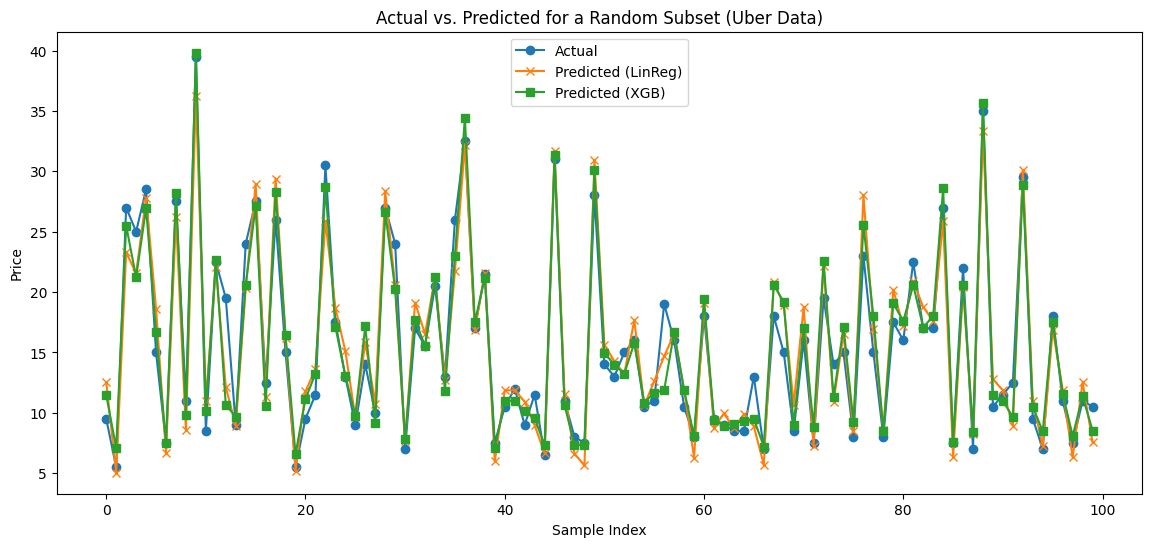

In [ ]:
# Line Plot
sample_df = df_compare.sample(n=100, random_state=42).reset_index(drop=True)
# (used generative AI to help in this plot)
plt.figure(figsize=(14, 6))
plt.plot(sample_df.index, sample_df["Actual"], label="Actual", marker='o')
plt.plot(sample_df.index, sample_df["Predicted_LinReg"], label="Predicted (LinReg)", marker='x')
plt.plot(sample_df.index, sample_df["Predicted_XGB"], label="Predicted (XGB)", marker='s')
plt.title("Actual vs. Predicted for a Random Subset (Uber Data)")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

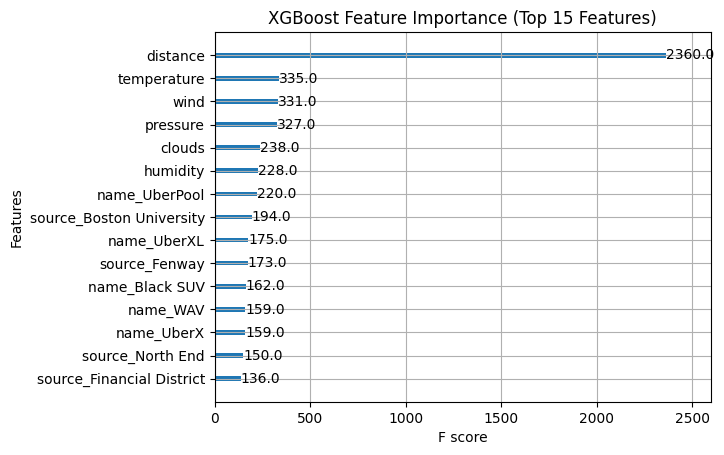

In [89]:
# Built-in XGBoost plot_importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_reg, max_num_features=15, xlabel="F score")  
plt.title("XGBoost Feature Importance (Top 15 Features)")
plt.show()